<a href="https://colab.research.google.com/github/CH2-PS226/Machine-Learning/blob/main/Capstone_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Capstone model

In [1]:
import urllib.request
import zipfile
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [2]:
mobilenetv2 = 'https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5'
urllib.request.urlretrieve(
    mobilenetv2, 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5')
local_weights_file = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5'

pre_trained_model =  MobileNetV2(
    input_shape = (305,305,3),
    include_top = False,
    weights = local_weights_file,
)


for layer in pre_trained_model.layers:
        layer.trainable = False


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
local_file = '/content/drive/MyDrive/ai_art_classification.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('data')



In [5]:
data_dir = 'data/ai_art_classification/train'

datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2,
                                   fill_mode='nearest')

train_generator=datagen.flow_from_directory(
        data_dir,
        batch_size=32,
        class_mode='binary',
        subset="training",
        shuffle=True,
        target_size=(305,305)
    )


validation_generator = datagen.flow_from_directory(
        data_dir,
        batch_size=32,
        class_mode='binary',
        subset="validation",
        shuffle=False,
        target_size=(305,305)
    )

Found 3546 images belonging to 2 classes.
Found 885 images belonging to 2 classes.


In [6]:
Desired_acc = 0.91
Desired_val_acc = 0.9010
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if((logs.get('acc')  is not None and logs.get('acc') >= Desired_acc) and (logs.get('val_acc')  is not None and logs.get('val_acc') >= Desired_val_acc)):
            print("\nalready meet, cancelling process")
            self.model.stop_training = True

callback = mycallback()

In [7]:
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_acc',
    patience =  3,
    verbose=1,
    ##mode = 'max'
    restore_best_weights=True
)


In [8]:
input = pre_trained_model.input
x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(1024, activation = 'relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs = input, outputs=output)

model.compile(optimizer=Adam(lr=0.0001),
    loss='binary_crossentropy',
    metrics=['acc'])


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 305, 305, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 153, 153, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 153, 153, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 153, 153, 32)         0         ['bn_Conv1[0][0]']        

In [9]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 30,
    #steps_per_epoch=30,
    verbose = 1,
    callbacks= [callback]
    )

Epoch 1/30
111/111 [==============================] - 146s 1s/step - loss: 4.2518 - acc: 0.8376 - val_loss: 0.3953 - val_acc: 0.8780
Epoch 2/30
111/111 [==============================] - 116s 1s/step - loss: 0.3503 - acc: 0.8869 - val_loss: 0.4827 - val_acc: 0.8893
Epoch 3/30
111/111 [==============================] - 112s 1s/step - loss: 0.2416 - acc: 0.9055 - val_loss: 0.3577 - val_acc: 0.8814
Epoch 4/30
111/111 [==============================] - 113s 1s/step - loss: 0.2311 - acc: 0.9134 - val_loss: 0.2747 - val_acc: 0.8904
Epoch 5/30
111/111 [==============================] - 131s 1s/step - loss: 0.1878 - acc: 0.9193 - val_loss: 0.2718 - val_acc: 0.8949
Epoch 6/30
111/111 [==============================] - 114s 1s/step - loss: 0.1704 - acc: 0.9312 - val_loss: 0.2852 - val_acc: 0.8893
Epoch 7/30
111/111 [==============================] - 113s 1s/step - loss: 0.1816 - acc: 0.9295 - val_loss: 0.5035 - val_acc: 0.8181
Epoch 8/30
111/111 [==============================] - ETA: 0s - loss:

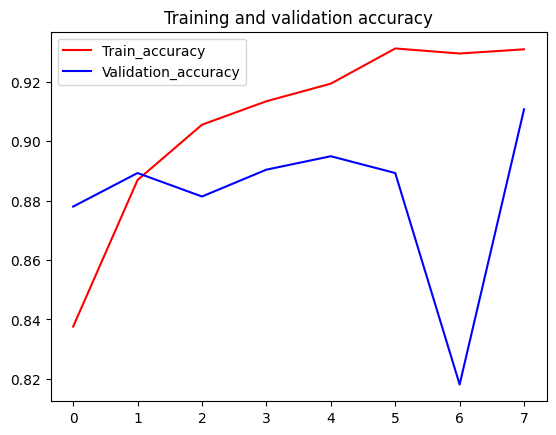

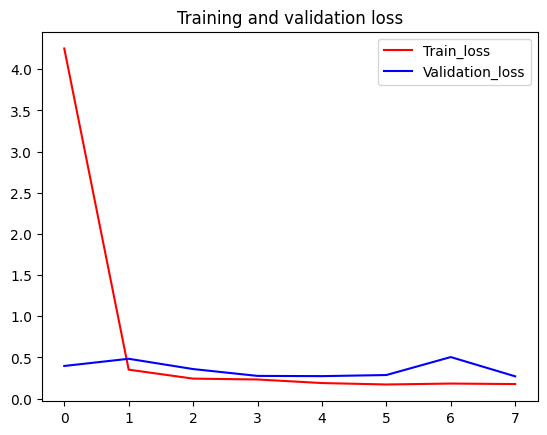

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Train_accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation_accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Train_loss')
plt.plot(epochs, val_loss, 'b', label='Validation_loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()


In [11]:
import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

user_input=files.upload()

for fn in user_input.keys():

  # predicting images
  path='/content/' + fn
  gmbr=load_img(path, target_size=(305, 305))

  x=img_to_array(gmbr)
  x /= 255
  x=np.expand_dims(x, axis=0)
  gambar_pred = np.vstack([x])

  classes = model.predict(gambar_pred, batch_size=10)

  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a human art")
  else:
    print(fn + " is an ai art")


Saving ai.jpg to ai.jpg
1/1 [==============================] - 2s 2s/step
[0.04576349]
ai.jpg is an ai art


In [12]:
model.save("Capstone_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
